
Dataset 'salary_data_cleaned.csv' loaded successfully.
First 5 rows of data:
                   Job Title              Salary Estimate  \
0             Data Scientist   $53K-$91K (Glassdoor est.)   
1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2             Data Scientist   $80K-$90K (Glassdoor est.)   
3             Data Scientist   $56K-$97K (Glassdoor est.)   
4             Data Scientist  $86K-$143K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc. is a high growth information sec...     4.8   
3  *Organization and Job ID**\nJob ID: 310709\n\n...     3.8   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

                                 Company Name         Location  \
0                      Tecolote Research\n3.8  Albuquerque, NM   
1  University of Maryland Medical Syst

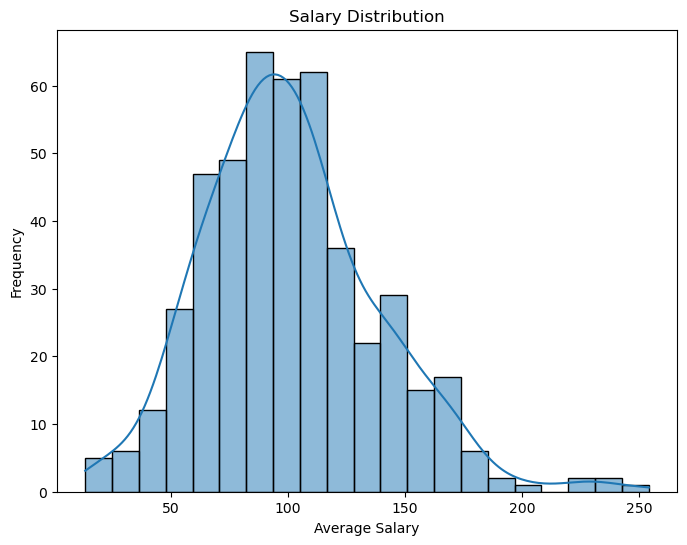

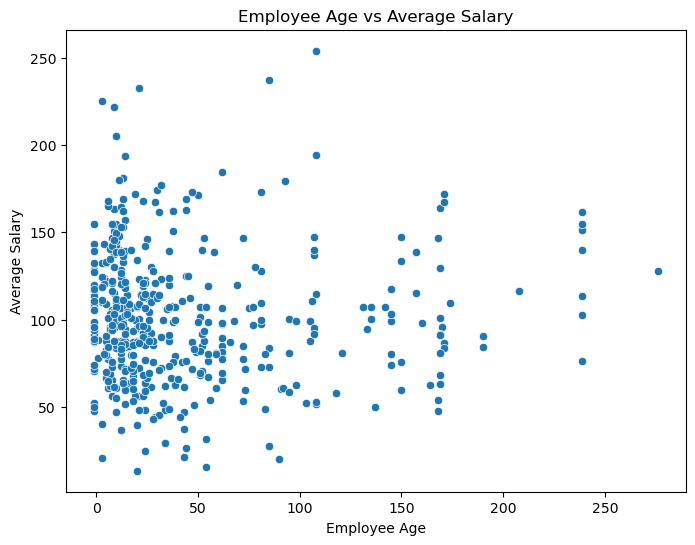

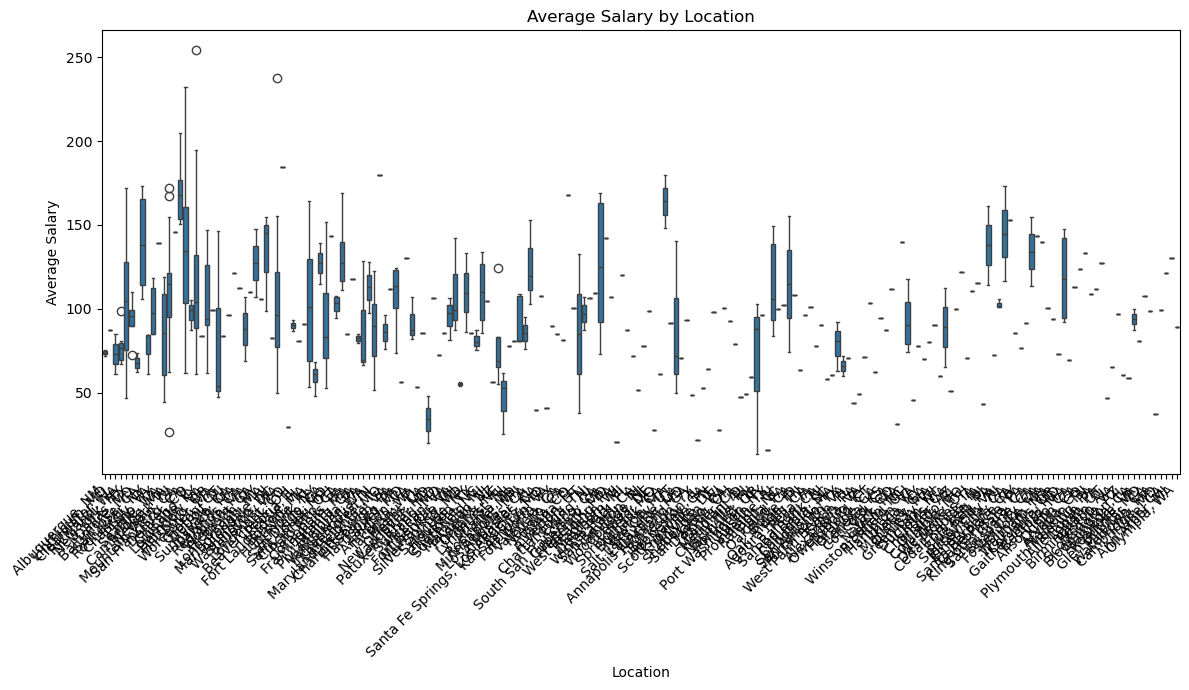


Applying Outlier Detection and Removal (IQR Method)...
Average Salary outliers removed. Rows before: 467, Rows after: 459
Age outliers removed. Rows before: 467, Rows after: 411

Handling rare categories in 'Job Title'...
Rare Job Titles replaced with 'Other'.

Numeric features identified: ['Rating', 'age', 'min_salary', 'max_salary', 'hourly', 'employer_provided', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'same_state']
Nominal features identified: ['Job Title', 'Location', 'Type of ownership', 'Industry', 'Sector', 'job_state']

Preprocessing pipeline created.

Data split into training (328 samples) and testing (83 samples) sets.

Training and evaluating models:

--- Model: Linear Regression ---
Mean Absolute Error: 0.00
Root Mean Squared Error: 0.00
R-squared: 1.00

--- Model: Decision Tree ---
Mean Absolute Error: 2.27
Root Mean Squared Error: 3.33
R-squared: 0.99

--- Model: Random Forest ---
Mean Absolute Error: 1.57
Root Mean Squared Error: 2.51
R-squared: 1.00

--- Model: X

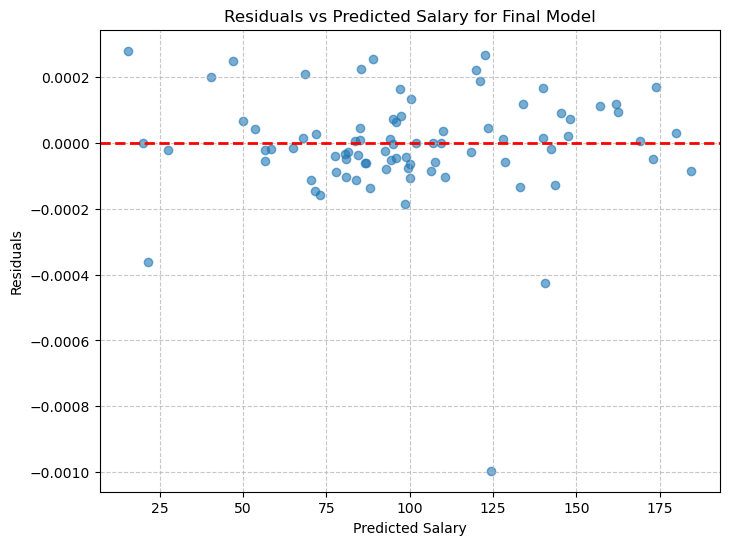


Feature importance plotting is not applicable for Linear Regression (not a tree-based model).


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb # Ensure xgboost is installed (e.g., pip install xgboost)

import joblib

warnings.filterwarnings("ignore")

# --- IMPORTANT: Dummy Data Generation section has been removed. ---
# This script now expects 'salary_data_cleaned.csv' to be present in the same directory.

# Step 2: Load Dataset
# Loads the provided 'salary_data_cleaned.csv' into a pandas DataFrame.
try:
    data = pd.read_csv("salary_data_cleaned.csv")
    print("\nDataset 'salary_data_cleaned.csv' loaded successfully.")
    print("First 5 rows of data:")
    print(data.head())
    # --- ADDED: Print all column names to help debug KeyError ---
    print("\nColumns in the loaded dataset:")
    print(data.columns.tolist())
    # -----------------------------------------------------------
except FileNotFoundError:
    print("Error: 'salary_data_cleaned.csv' not found. Please ensure the file is in the correct directory.")
    exit() # Exit if the file is not found

# Step 3: Data Cleaning
# Checks for missing values, drops rows with any missing data, and removes duplicate rows.
print("\nChecking for missing values:")
print(data.isnull().sum())
# Check if there are any missing values before attempting dropna
if data.isnull().sum().sum() > 0:
    data.dropna(inplace=True)
    print("Missing values handled by dropping rows.")
else:
    print("No missing values found.")

# Check for duplicates before attempting drop_duplicates
if data.duplicated().sum() > 0:
    data.drop_duplicates(inplace=True)
    print("Duplicate rows handled.")
else:
    print("No duplicate rows found.")

print("\nData cleaning completed.")


# Step 4: EDA - Exploratory Data Analysis
# Provides insights into the dataset's structure, statistics, and distributions.
print("\nData Types:")
print(data.dtypes)

print("\nSummary Statistics:")
print(data.describe())

# --- Check for 'avg_salary' column before plotting and use it ---
if 'avg_salary' not in data.columns:
    print("\nError: 'avg_salary' column not found in the dataset for EDA. Please check your CSV file's column names.")
    # You might want to exit or skip further steps that rely on 'avg_salary'
else:
    # Plotting Salary Distribution
    # Visualizes the distribution of salaries using a histogram and KDE plot.
    plt.figure(figsize=(8, 6))
    sns.histplot(data['avg_salary'], kde=True)
    plt.title("Salary Distribution")
    plt.xlabel("Average Salary") # Updated label
    plt.ylabel("Frequency")
    plt.show()

    # Scatter plot between YearsExperience (now 'age') and avg_salary
    # Using 'age' as the proxy for experience as per the dataset columns
    if 'age' in data.columns:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x='age', y='avg_salary', data=data)
        plt.title("Employee Age vs Average Salary") # Updated title
        plt.xlabel("Employee Age")
        plt.ylabel("Average Salary") # Updated label
        plt.show()
    else:
        print("Warning: 'age' column not found for scatter plot. Please verify your dataset columns.")

    # Boxplot for Location vs avg_salary
    # Compares salary distributions across different locations.
    if 'Location' in data.columns:
        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Location', y='avg_salary', data=data) # Updated column name
        plt.title("Average Salary by Location") # Updated title
        plt.xlabel("Location")
        plt.ylabel("Average Salary") # Updated label
        plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()
    else:
        print("Warning: 'Location' column not found for box plot.")


# Step 5: Outlier Detection and Removal (IQR Method)
# Identifies and removes outliers in 'avg_salary' and 'age' using the IQR method
# to improve model robustness.
print("\nApplying Outlier Detection and Removal (IQR Method)...")
if 'avg_salary' in data.columns:
    Q1 = data['avg_salary'].quantile(0.25)
    Q3 = data['avg_salary'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_salary_rows = data.shape[0]
    data = data[(data['avg_salary'] >= lower_bound) & (data['avg_salary'] <= upper_bound)]
    print(f"Average Salary outliers removed. Rows before: {initial_salary_rows}, Rows after: {data.shape[0]}")
else:
    print("Warning: 'avg_salary' column not found for outlier removal.")

if 'age' in data.columns: # Using 'age' as the numerical feature for outlier detection
    Q1_age = data['age'].quantile(0.25)
    Q3_age = data['age'].quantile(0.75)
    IQR_age = Q3_age - Q1_age
    low_age = Q1_age - 1.5 * IQR_age
    high_age = Q3_age + 1.5 * IQR_age
    data = data[(data['age'] >= low_age) & (data['age'] <= high_age)]
    print(f"Age outliers removed. Rows before: {initial_salary_rows}, Rows after: {data.shape[0]}")
else:
    print("Warning: 'age' column not found for outlier removal. Please verify your dataset columns.")


# Step 6: Handle Rare Categories
# Groups job titles with less than 10 occurrences into an 'Other' category to reduce
# the dimensionality of one-hot encoded features and improve model generalization.
print("\nHandling rare categories in 'Job Title'...")
# Ensure 'Job Title' column exists before proceeding
if 'Job Title' in data.columns:
    job_counts = data['Job Title'].value_counts()
    rare_jobs = job_counts[job_counts < 10].index
    data['Job Title'] = data['Job Title'].replace(rare_jobs, 'Other')
    print("Rare Job Titles replaced with 'Other'.")
else:
    print("Warning: 'Job Title' column not found. Skipping rare category handling for Job Title.")


# Step 7: Feature Preparation
# Defines feature types (numeric, nominal) based on the actual dataset columns.
# The 'EducationLevel' and 'Gender' columns from previous versions are not in this dataset.

# Ensure 'avg_salary' column exists before dropping it
if 'avg_salary' not in data.columns:
    print("Error: 'avg_salary' column not found in the dataset. Cannot proceed with feature preparation.")
    exit()

# Define features to drop from X, including original string columns that were not features
columns_to_drop_from_X = [
    'avg_salary', 'Salary Estimate', 'Job Description', 'Company Name',
    'Headquarters', 'Size', 'Founded', 'Revenue', 'Competitors', 'company_txt'
]

# Filter X to only include columns that are actual features and not the target or irrelevant
X = data.drop(columns=[col for col in columns_to_drop_from_X if col in data.columns], errors='ignore')
y = data['avg_salary']

# Dynamically determine features based on available columns in the dataset after dropping irrelevant ones
numeric_features = [
    col for col in ['Rating', 'age', 'min_salary', 'max_salary', 'hourly',
                    'employer_provided', 'python_yn', 'R_yn', 'spark', 'aws', 'excel', 'same_state']
    if col in X.columns
]
nominal_features = [
    col for col in ['Job Title', 'Location', 'Type of ownership', 'Industry', 'Sector', 'job_state']
    if col in X.columns
]

# Print current feature lists for verification
print(f"\nNumeric features identified: {numeric_features}")
print(f"Nominal features identified: {nominal_features}")

# Step 8: Create Preprocessing Pipeline
# Sets up a ColumnTransformer to apply different preprocessing steps to different
# types of features (scaling for numeric, one-hot encoding for nominal).
# OrdinalEncoder is removed as 'EducationLevel' is not present.
transformers_list = []
if numeric_features:
    transformers_list.append(('num', StandardScaler(), numeric_features))
if nominal_features:
    transformers_list.append(('nom', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features))

if not transformers_list:
    print("Error: No valid features found for preprocessing. Please check your dataset columns and feature definitions.")
    exit()

preprocessor = ColumnTransformer(
    transformers=transformers_list,
    remainder='passthrough' # Keep other columns not specified in transformers (should be none now if columns_to_drop_from_X is comprehensive)
)
print("\nPreprocessing pipeline created.")

# Step 9: Split Data into Training and Testing
# Divides the dataset into training and testing sets for model development and evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")

# Step 10: Train and Evaluate Multiple Models
# Iterates through different regression models, trains them within a pipeline
# (preprocessing + regressor), and evaluates their performance using MAE, RMSE, and R2 score.
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror') # Corrected typo here
}

results = {}

print("\nTraining and evaluating models:")
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

    print(f"\n--- Model: {name} ---")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"R-squared: {r2:.2f}")

# Step 11: Cross-Validation for Robust Evaluation
# Performs 5-fold cross-validation for each model to get a more robust estimate of
# their performance and generalization ability.
print("\n--- Performing Cross-Validation ---")
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    scores = cross_val_score(pipe, X, y, scoring='r2', cv=5)
    print(f"{name} - Cross-Validation R²: {scores.mean():.4f} (±{scores.std():.4f})")

# Step 12: Select and Retrain Best Model on Full Data
# Identifies the best performing model based on RMSE and retrains it on the entire dataset
# to maximize its learning from all available data.
best_model_name = min(results, key=lambda x: results[x]['RMSE'])
print(f"\nBest model selected based on RMSE: {best_model_name}")

final_model = models[best_model_name]
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_model)
])
final_pipeline.fit(X, y) # Retrain on full data
print(f"Final model ({best_model_name}) retrained on the entire dataset.")

# Step 13: Save the Final Model
# Saves the trained pipeline to a file using joblib for future use without retraining.
joblib.dump(final_pipeline, 'salary_predictor_model.pkl')
print("\nModel saved successfully as salary_predictor_model.pkl")

# Step 14: Save Evaluation Results to CSV
# Exports the performance metrics of all evaluated models to a CSV file.
results_df = pd.DataFrame(results).T
results_df.to_csv("model_evaluation_report.csv")
print("Model evaluation report saved as model_evaluation_report.csv")

# Step 15: Plot Residuals for Final Model
# Visualizes the residuals (prediction errors) of the final model to check for patterns
# or biases in predictions. Ideally, residuals should be randomly scattered around zero.
y_pred_final = final_pipeline.predict(X_test)
residuals = y_test - y_pred_final

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title("Residuals vs Predicted Salary for Final Model")
plt.xlabel("Predicted Salary")
plt.ylabel("Residuals")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Step 16: Feature Importance for Tree-Based Models
# If the best model is tree-based (Random Forest or XGBoost), this section extracts
# and plots the importance of each feature in making predictions.
if best_model_name in ["Random Forest", "XGBoost"]:
    print(f"\n--- Feature Importances for {best_model_name} ---")
    # Get feature names after preprocessing, including one-hot encoded columns
    # The get_feature_names_out() method of ColumnTransformer is used to get the names
    # of the features after all transformations have been applied.
    feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
    importances = final_pipeline.named_steps['regressor'].feature_importances_

    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10, max(6, len(feat_imp) * 0.4))) # Adjust figure height dynamically
    sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
    plt.title(f"Feature Importances for {best_model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print(f"\nFeature importance plotting is not applicable for {best_model_name} (not a tree-based model).")
